<a href="https://colab.research.google.com/github/Nautyy9/DC_GAN/blob/main/DCGAN_36hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential, Model, layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# GAN  are more difficult to train then other neural network since here we've 2 adverseries (Generator and Discriminator) both working hand on hand , one try to maximize the loss and other try to minimize the loss
# NOW , Maximized mean y(cap) must be 1 and Minimized means y(cap) must be 0

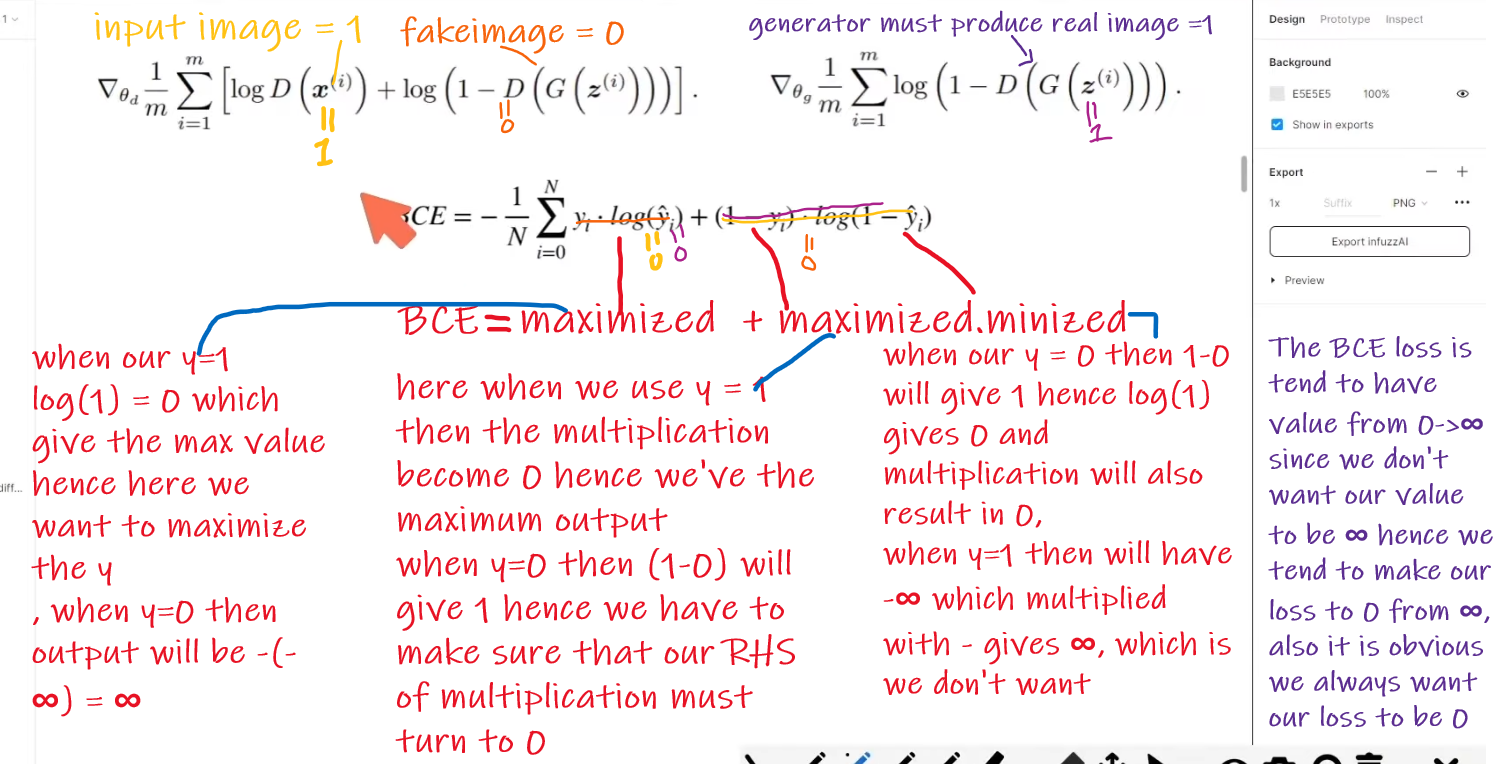

#### D(x(i)) == ŷ == D(G(z(i))) , where z(i) == sample of real image


```
ŷ = what model predicts
y = labels
```



```
<!-- NOW WE KNOW A STARTING , THE GAN MODEL HAS EASY WAY OF PREDICTING THE FAKE IMAGE SINCE THE GENERATOR DOESN'T STABLIZE AT START , HENCE WE SEE OUR DISCRIMINATOR WILL PRODUCE 0 AS OUTPUT AT START FOR FAKE DETECTION -->
<!-- IT IS PROBLEM BECAUSE THE OUTPUT 0 WILL NOT UPDATE OUR WEIGHTS AND THUS RESULT IN VANISHING GRADIENT  -->
<!-- TO AVOID IT WE PRODUCE OUTPUT 1 WHEN A FAKE IMAGE IS DETECTED RESULTING UPDATED WEIGHTS  -->
<!-- WE USE 1/N(∑log(D(G(z(i))))) INSTEAD OF 1/N(∑log(1- D(G(z(i))))) , because the previous one will give output as 1 in discrimintor hence updating weights-->
```


```
# clearing a bit of confusion , we've loss for generator and discriminator in VAE model where we are using gradient ascend for discriminator and gradient descend for generator
   and our discriminator has a real image = 1(D(x(i))d = 1) and fake_image = 0( D(G(z(i)))d = 0 ), but our generator must produce the real image hence we must have to have  D(G(z(i)))g =1
# so when we put the required 1 or 0 values for discriminator and generator will get the following output which are leading to 0
# above is just show case of what happen when will put the values 1 or 0 defined

```



*   in the BCE loss above , we just doing what we're doing in VAE BCE loss but the difference is in the arithematic operations, in VAE BCE loss we are having values from -∞ to 0 , but in DCGAN BCE loss we've loss from 0 to ∞, there we're trying to maximize the loss(generator)(not the training_loss) , here we try to minize the loss






In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

In [ ]:
# print(tf.random.normal(shape=(64,100)))

tf.Tensor(
[[-0.36199343 -1.4203135  -1.030008   ...  0.6570133   1.2241312
   0.56812906]
 [-1.7965037   0.03371103 -0.23741215 ...  0.9706901   1.3129637
   0.16112602]
 [ 2.1066484  -1.2692745  -0.7417377  ...  2.074337    1.2585933
  -0.244515  ]
 ...
 [ 0.86834455 -1.5207028   1.7258457  ...  0.33965322  0.6660872
  -0.8813929 ]
 [-0.8622527  -0.4658928  -1.4915912  ... -0.02146481  0.7783794
  -2.2236674 ]
 [-0.51633865 -0.6009767   1.9435496  ... -0.8064283   0.05806303
  -1.1747552 ]], shape=(64, 100), dtype=float32)


In [ ]:
batch_size = 128
im_shape = (64,64,3)
lr = 2e-4
latent_dim=100
epochs=20

In [ ]:
# default image size is (224,224,3) but for eaze of plotting we use 64,64,3 channels
# now our latent dimension is 100 as per paper

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(im_shape[0], im_shape[1]), batch_size=batch_size
)

In [ ]:
# we want our image to be in between -1 and 1 hence we need to preprocess our image

def preprocess(image):
  return tf.cast(image, tf.float32)/127.5 - 1.0

In [ ]:
# used map to convert images from -1 to 1 , drop remainder = True
#  unbatch before shuffling
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

In [ ]:
# now our image is b/w -1  and 1 but our plot can only show img b/w 0,1 hence we d+1/2
# d is from above for loop
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2,k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

# Modeling

In [ ]:
generator = Sequential([
    Input(shape=(latent_dim,)),
    Dense(4*4*latent_dim),
    Reshape((4,4,latent_dim)),

    Conv2DTranspose(512, 4, strides=2 padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),


    Conv2DTranspose(256, 4, strides=2 padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),


    Conv2DTranspose(128, 4, strides=2 padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    # we've used tanh cause we want our image from -1 to 1
    Conv2DTranspose(3,  4, strides=2 padding='same', activation=tf.keras.activations.tanh, padding="same"),
], name="generator")
